<a href="https://colab.research.google.com/github/luisanovaes/ufam_project/blob/main/topification_evaluation_2_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Acesso ao drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading functions

In [2]:
import pandas as pd
from collections import Counter
import json
import re

# Index(['Unnamed: 0', 'Document_id', 'Dominant_Topic', 'Topic_Perc_Contrib',
#        'Top5_Topics', 'Ementa', 'Q', 'S'], dtye='object')

def generate_dominant_map(csv_filepath: str) -> map:
    df = pd.read_csv(csv_filepath, sep=",")
    return dict(zip(df.Document_id, df.Dominant_Topic))


def generate_topK_max_map(csv_filepath: str) -> map:
    df = pd.read_csv(csv_filepath, sep=",")
    return dict(zip(df.Document_id, df.Top5_Topics))


def generate_document_map(json_file: str) -> map:
    with open(json_file) as json_data:
        data = json.load(json_data)
        return data

def generate_top_k_map(csv_filepath: str, k: int) -> map:
    df = pd.read_csv(csv_filepath, sep=",")
    result_map = dict(zip(df.Document_id, df.Top5_Topics))
    # print("Pre-filtering map:", result_map)
    filtered_map = remove_all_elements_greater_than_k(result_map, k)
    #print("Filtered on top K map:", filtered_map)
    return filtered_map


def remove_all_elements_greater_than_k(input_map : map, cut_value: int) -> map:
    new_map = dict()
    for (key, v) in input_map.items():
        l = str_to_list(v)
        new_map[key] = build_str(l, cut_value)
    return new_map

def match_dominant(doc_to_dominant_topic: map, doc_to_refs: map) -> map:
    result = Counter()
    for (doc, v) in doc_to_refs.items():
        for ref in doc_to_refs[doc]:
            if (doc_to_dominant_topic[ref] == doc_to_dominant_topic[doc]):
                result[doc] = result[doc] + 1
        result[doc] = result[doc] / len(doc_to_refs[doc])
    return result

#ALTERNATIVA 1: Avaliar a presença do tópico dominante da QUERY nos top k tópicos dominantes da RESPOSTA 
def dominant_inside_top_k_type1(doc_to_dominant_topic: map, doc_to_top_k: map, doc_to_refs: map) -> map:
    result = Counter()
    for (doc, v) in doc_to_refs.items(): #([('048771.txt', ['038112.txt', '026070.txt']), (...)])
      try:
        for ref in doc_to_refs[doc]: # ['038112.txt', '026070.txt']
          query_dominant = doc_to_dominant_topic[doc] #13
          top_k_from_ref = doc_to_top_k[ref].replace("[","").replace("]","").split(' ') # ['94', '5', '105', '3', '20']
          if (convert_float_to_int_string(query_dominant) in top_k_from_ref):
            result[doc] = result[doc] + 1
      except:
        result[doc] = result[doc] + 0     
      result[doc] = result[doc] / len(doc_to_refs[doc])
    return result



#ALTERNATIVA 2: #AJUSTAR O doc_to_dominant_topic pra não pegar todos os docs; Avaliar a presença do tópico dominante da RESPOSTA nos top k tópicos dominantes da QUERY ; 
def dominant_inside_top_k_type2(doc_to_dominant_topic: map, doc_to_top_k: map, doc_to_refs: map) -> map:
    result = Counter()
    for (doc, v) in doc_to_refs.items(): #([('048771.txt', ['038112.txt', '026070.txt']), (...)])
      try:
        for ref in doc_to_refs[doc]: # ['038112.txt', '026070.txt']
          reference_dominant = doc_to_dominant_topic[ref] #94.0
          top_five_from_doc = doc_to_top_k[doc].replace("[","").replace("]","").split(' ') # ['13', '19', '20', '35', '3', '101', '7', '107', '25', '75']
          if (convert_float_to_int_string(reference_dominant) in top_five_from_doc):
            result[doc] = result[doc] + 1
      except:
        result[doc] = result[doc] + 0    
      result[doc] = result[doc] / len(doc_to_refs[doc])
    return result


def convert_float_to_int_string(value: float) -> str:
    return str(int(float(value)))

def str_to_list(value: str) -> list:
    cleaned_v = value.replace("]", "").replace("[", "").strip()
    return re.split("\s+", cleaned_v)


def build_str(l: list, cut_value: int) -> str:
   return "[" + " ".join(l[0:cut_value]) + "]"

def references_agreement_on_topic(doc_to_dominant_topic: map, doc_to_refs: map) -> map:
    result = Counter()
    for (doc, v) in doc_to_refs.items(): #([('048771.txt', ['038112.txt', '026070.txt']), (...)])
        tmp_counter = Counter()
        for ref in doc_to_refs[doc]:
            reference_dominant_value = doc_to_dominant_topic[ref]
            tmp_counter[reference_dominant_value] = tmp_counter[reference_dominant_value] + 1
        result[doc] = (tmp_counter.most_common(1)[0][0], tmp_counter.most_common(1)[0][1]/len(doc_to_refs[doc]))
    return result

def write_document_map_to_csv(map: map, filename: str) -> None:
    print("To write at file: " + "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/evaluation/"+filename)
    with open("/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/results"+filename,'w',encoding = 'utf-8') as f:
        f.write("document,percentual\n")
        for (k,v) in map.items():
            f.write( str(k) + "," + str(v) + "\n" )


def write_agreement_analysis_to_csv(map: map, filename: str) -> None:
    print("To write at file: "+"/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/evaluation/"+filename)
    with open("/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/evaluation/"+filename,'w+',encoding = 'utf-8') as f:
        f.write("document,topic_dominant_id_agreed, percentual_of_the_agreement\n")
        for (k,v) in map.items():
            topic_agreed = convert_float_to_int_string(v[0])
            percentual_of_agreement = str(v[1])
            f.write( str(k) + "," + topic_agreed + ","+ percentual_of_agreement + "\n" )



In [3]:
#Select >candidate topics< considering the Perc of Contrib from the dominant topic > threshould

def generate_top_k_map_threshold(csv_filepath: str, k: int, threshold) -> map:
    df = pd.read_csv(csv_filepath, sep=",")
    result_list_raw = (pd.DataFrame(zip(df.Document_id, df.Topic_Perc_Contrib, df.Top5_Topics), columns = ['Document_id', 'Topic_Perc_Contrib', 'Top5_Topics']))
    #print("Pre-filtering map:", result_list_raw)
    result_after_threshold = result_list_raw[result_list_raw['Topic_Perc_Contrib'] > threshold]
    result_map = dict(zip(result_after_threshold['Document_id'],result_after_threshold['Top5_Topics']))
    #INSERT QUERY DOCS BACK
    query_map = generate_top_k_map(queries_to_dominant_topic,k)
    final_map = {**query_map,**result_map}
    #print("Filtered on top K map:", result_map)
    filtered_map = remove_all_elements_greater_than_k(final_map, k)
    #print("Filtered on top K map:", filtered_map)
    return filtered_map


#this one without a threshould
def generate_top_k_map(csv_filepath: str, k: int) -> map:
    df = pd.read_csv(csv_filepath, sep=",")
    result_map = dict(zip(df.Document_id, df.Top5_Topics)) # TOP K
    # print("Pre-filtering map:", result_map)
    filtered_map = remove_all_elements_greater_than_k(result_map, k)
    # print("Filtered on top K map:", filtered_map)
    return filtered_map


# Load docs

In [4]:
# Input files
bert_result_file = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/results/bertopic_documents_final-k-max.csv"
document_references_file = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/task1_train_labels.json"
queries_to_dominant_topic = "/content/drive/MyDrive/Colab-Notebooks/luisa-novaes/queries.csv"
 

# K fixo e threshold x variável

In [55]:
# Compute the maps for analysis
#dict: doc -> dominant topic ; 4415 items; {'021359.txt': 20.0, '028184.txt': 0.0 ....}
doc_to_dominant_topic = generate_dominant_map(bert_result_file)
#dict: queries -> answers ; 650 items; {'008447.txt': ['072495.txt', '082291.txt',...]...}
doc_to_refs = generate_document_map(document_references_file) 
#dict: doc -> top K dominant topics ; 4415 items; {'021359.txt': '[20 3 19 13 105]', ...}
doc_to_top_k_fixed = generate_top_k_map(bert_result_file,10) 

# Generate analysis
import statistics

#For k = 10
k=50
#Threshold
threshold= 0.0

## Compute the maps for analysis
#dict: doc -> dominant topic ; 4415 items; {'021359.txt': 20.0, '028184.txt': 0.0 ....}
doc_to_dominant_topic = generate_dominant_map(bert_result_file)

#dict: queries -> answers ; 650 items; {'008447.txt': ['072495.txt', '082291.txt',...]...}
doc_to_refs = generate_document_map(document_references_file) 

#dict: doc -> top K=5 dominant topics, threhold = 0.2 ;  items; {'021359.txt': '[20 3 19 13 105]', ...}
doc_to_top_k_threshold = generate_top_k_map_threshold(bert_result_file,k,threshold)


# Generate analysis
import statistics

#Recall top K (References inside Top 5): % of reference dominant topics which is inside the document top five
refs_inside_top_k = dominant_inside_top_k_type1(doc_to_dominant_topic, doc_to_top_k_threshold, doc_to_refs)



print("References inside Top K: ", refs_inside_top_k, '\n')
mean3 = statistics.mean(refs_inside_top_k.values())
median = statistics.median(refs_inside_top_k.values())
print(mean3)
print(median)

#write_document_map_to_csv(refs_inside_top_k, "type1_top_10_with_x=04.csv")


References inside Top K:  Counter({'008447.txt': 1.0, '067501.txt': 1.0, '007627.txt': 1.0, '006769.txt': 1.0, '007876.txt': 1.0, '078422.txt': 1.0, '000123.txt': 1.0, '043774.txt': 1.0, '031183.txt': 1.0, '039087.txt': 1.0, '008653.txt': 1.0, '030394.txt': 1.0, '043815.txt': 1.0, '076001.txt': 1.0, '001499.txt': 1.0, '006704.txt': 1.0, '068182.txt': 1.0, '031284.txt': 1.0, '046467.txt': 1.0, '004108.txt': 1.0, '040560.txt': 1.0, '016618.txt': 1.0, '088711.txt': 1.0, '078681.txt': 1.0, '070711.txt': 1.0, '050190.txt': 1.0, '060807.txt': 1.0, '008771.txt': 1.0, '087599.txt': 1.0, '009186.txt': 1.0, '038947.txt': 1.0, '046489.txt': 1.0, '015031.txt': 1.0, '074582.txt': 1.0, '000092.txt': 1.0, '089555.txt': 1.0, '057136.txt': 1.0, '079913.txt': 1.0, '076990.txt': 1.0, '092332.txt': 1.0, '024157.txt': 1.0, '085841.txt': 1.0, '069872.txt': 1.0, '007667.txt': 1.0, '024481.txt': 1.0, '098226.txt': 1.0, '060686.txt': 1.0, '099856.txt': 1.0, '058009.txt': 1.0, '001510.txt': 1.0, '069976.txt': 1

# Avaliacao para diferentes Ks

In [ ]:
#Vary K from x to y, adding 5
k = list(range(0,120,5))

#define threshold 
threshold = 0.0

# Compute the maps for analysis
doc_to_dominant_topic = generate_dominant_map(bert_result_file) #dict: doc -> dominant topic ; 4415 items
doc_to_refs = generate_document_map(document_references_file) #dict: query -> answers ; 650 items (queries)


#generate many maps 
top_k = []
for i in k:
  #top_k.append(generate_top_k_map(bert_result_file,i)) # no threshould considered
  top_k.append(generate_top_k_map_threshold(bert_result_file,i,threshold))

answers = []
for key in top_k:
 try: 
  recall_k = dominant_inside_top_k_type1(doc_to_dominant_topic, key, doc_to_refs)
  avg_recall = statistics.mean(recall_k.values())
  answers.append(avg_recall)
 except:
  continue


In [ ]:
for number in answers:
  print("{:10.4f}".format(number)) 


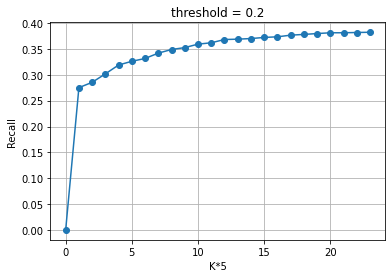

In [ ]:
#plot recall vs K

import matplotlib.pyplot as plt 

#k.insert(0, '1')
x = k
#answers.insert(0,'0.46')
y=answers

plt.xlabel("K*5")
plt.ylabel("Recall")
plt.title('threshold = 0.2')
plt.plot(y, marker = 'o')
plt.grid()
plt.show()  

# Avaliação final: Precision e Recall com K máximo (K=117)

In [6]:
# GeraR a list de docs, K tÓPICOS dominantes e Perc contrib
def generate_map_doc_percent_contrib(csv_filepath) -> map:
    df = pd.read_csv(csv_filepath, sep=",")
    return dict(zip(df.Document_id, df.Topic_Perc_Contrib))

#FUNCAO COM ERRO, PRECISA SER AJUSTADA
#Gerar listas que docs que possuem o tópico dominante z da query no Top k, e em que posição esse tópico aparece
def query_to_filtered_candidates(documents_topk_map, query_to_dominant):
    filtered_candidates = dict()
    for (query, query_topic) in query_to_dominant.items():
        answers=[]
        for (candidate, topk) in documents_topk_map.items():
            top_k_candidates = topk.replace("[","").replace("]","").split() # ['94', '5', '105', '3', '20']
            if (convert_float_to_int_string(query_topic) in top_k_candidates):
                index = top_k_candidates.index(convert_float_to_int_string(query_topic))
                answers.append([candidate,index+1])
            else:
                continue
        #answers.append([candidate,'NA'])
            filtered_candidates[query] = answers
    return filtered_candidates #  {'008447.txt': [['021359.txt', 16], ['028184.txt, 20], ...], '005484.txt': [[...]...]}


#Gerar um vetor: {query: {candidate->perc_contrib_final, candidate->perc_contrib_final, ...}, query: {}, ....}  
## Aplicar a formula : Perc_Contrib_final = Topic_Perc_Contrib / posição no vetor 

def query_to_candidates_perc_contrib(filtered_candidates,doc_to_perc_contrib):
 qc_final =dict()
 for query, candidates in filtered_candidates.items(): # {'025422.txt': [['021359.txt', 85], ['028184.txt', 34],...], '025532.txt': [[...]...]
     answers=dict()
     for sublist in candidates: # ['021359.txt', 85], ['028184.txt', 34],...]
         id,perc = sublist  #['021359.txt', 85]
         contrib = doc_to_perc_contrib[id] / perc
         answers[id]= contrib
     qc_final[query] = answers
 return qc_final




## Gerar lista de candidatos por query, DESC em rel ao perc_contrib_final

In [22]:
#Gerar doc ID -> topK map
documents_topk_map_max = generate_topK_max_map(bert_result_file) # '021359.txt': '[ 20   3  19  13 105 107  35...]',
#Gerar query -> doc dominante
query_to_dominant = generate_dominant_map(queries_to_dominant_topic) # {'008447.txt': 76, ...}
#Gerar doc->Perc_Contrib
doc_to_perc_contrib = generate_map_doc_percent_contrib(bert_result_file) # {'008447.txt': 76, ...}
#Gerar query -> refs
doc_to_refs = generate_document_map(document_references_file)

##Calcular o percentual_de_contrib do tópico
#1. Definir posicao do topico no vetor topk
qc_semifinal = query_to_filtered_candidates(documents_topk_map_max, query_to_dominant)

#2.Gerar um vetor: {query: {candidate->perc_contrib_final, candidate->perc_contrib_final, ...}, query: {}, ....}        
qc_final_all = query_to_candidates_perc_contrib(qc_semifinal,doc_to_perc_contrib)    

#3. Ordenar candidatos em relacao ao Perc_contrib_final decrescente
x = qc_final_all

for key, value in x.items():
    x[key] = dict(sorted(value.items(), key=lambda x: x[1],reverse=True))

qc_final_desc = x   # {'008447.txt': {'069049.txt': 1.0, '049315.txt':...} ...}

#print(qc_final_desc['008447.txt'])  #{'069049.txt': 1.0, '049315.txt': 1.0, '008447.txt': 1.0, ...}

#Create a vector: { Query -> [candidates], query -> [candidates] }

qc_final_clean = {}
for key, value in x.items():
    qc_final_clean[key] = set(value.keys())

print(qc_final_clean['078422.txt'])  #{'099321.txt', '017054.txt', '015022.txt', '025673.txt',...}

#print(filtered_candidates['078422.txt'])
#print(doc_to_dominant_topic['078422.txt'])

#print(documents_topk_map['021359.txt'])
#print(documents_topk_map['021359.txt'])



{'018629.txt', '044085.txt', '015599.txt', '045406.txt', '075046.txt', '093241.txt', '001572.txt', '026212.txt', '032629.txt', '036067.txt', '085782.txt', '036826.txt', '050729.txt', '022714.txt', '088089.txt', '052168.txt', '084661.txt', '091970.txt', '040647.txt', '000187.txt', '059544.txt', '079771.txt', '013034.txt', '027864.txt', '017172.txt', '081548.txt', '075535.txt', '026735.txt', '071378.txt', '060425.txt', '047718.txt', '015521.txt', '085516.txt', '028077.txt', '041704.txt', '050269.txt', '089172.txt', '091807.txt', '026334.txt', '033358.txt', '037429.txt', '094784.txt', '034516.txt', '097786.txt', '025897.txt', '032771.txt', '053322.txt', '065469.txt', '009539.txt', '011447.txt', '067329.txt', '008329.txt', '070768.txt', '046349.txt', '071821.txt', '023554.txt', '034072.txt', '063157.txt', '089102.txt', '080797.txt', '087485.txt', '047865.txt', '037117.txt', '081429.txt', '023005.txt', '042352.txt', '085369.txt', '007476.txt', '049423.txt', '026188.txt', '020336.txt', '0664

Seleção de candidados variando o K

In [ ]:
  ##Vetores de candidatos pra diferentes K's
#Vary K from x to y, adding 5
new_k = list(range(25,55,5))
#print(new_k)

 #define threshold 
threshold = 0.0

 #Compute the maps for analysis
#generate many maps 
top_k_maps = []
for i in new_k:
   top_k_maps.append(generate_top_k_map_threshold(bert_result_file,i,threshold))

#1. Definir posicao do topico no vetor topk
query_topic_position_map = [] 
for x in top_k_maps:
    query_topic_position_map.append(query_to_filtered_candidates(x, query_to_dominant))
 
#2.Gerar um vetor: {query: {candidate->perc_contrib_final, candidate->perc_contrib_final, ...}, query: {}, ....}        
query_candidate_contrib = []
for y in query_topic_position_map:
    query_candidate_contrib.append(query_to_candidates_perc_contrib(y,doc_to_perc_contrib))

#3. Ordenar candidatos em relacao ao Perc_contrib_final decrescente

w = query_candidate_contrib # [{'008447.txt': {'008447.txt': 1.0, '067501.txt': 9.090909090909092e-05, '006769.txt': 0.025595, '031183.txt': 0.0625, '053848.txt': 0.01718, ...}, '067501.txt': {'008447.txt': 0.045454545454545456, '067501.txt': 0.002, '006769.txt':
for item in w:
    for key, value in item.items():
        item[key] = dict(sorted(value.items(), key=lambda w: w[1],reverse=True))

qc_final_desc_Ks = w
 
#Create a vector: { Query -> [candidates], query -> [candidates] } for each K
final_results_Ks = []
for v in w:
    qc_final_clean_Ks = {}
    for key, value in v.items():
        qc_final_clean_Ks[key] = set(value.keys())
    final_results_Ks.append(qc_final_clean_Ks)

#Validation:
#print(len(final_results_Ks[0]['067501.txt'])) 
#print(len(final_results_Ks[1]['067501.txt'])) 
#print(len(final_results_Ks[2]['067501.txt'])) 



##Calculando Precision e Recall

In [42]:
import statistics

### Def Precision (R/D : D = Number of candidates )
def precision(qc_final_clean, queries_to_refs) -> map:
    precision_results= Counter()
    for query,candidates in qc_final_clean.items():
      for candidate in qc_final_clean[query]:
        if candidate in queries_to_refs[query]:
          precision_results[query] = precision_results[query] +1
      precision_results[query] = precision_results[query] / len(qc_final_clean[query])
    return precision_results

### Def Recall (R/D : D = Number of Relevants)
def recall(qc_final_clean, queries_to_refs) ->map:
  recall_results= Counter()
  for query,candidates in qc_final_clean.items():
    for candidate in qc_final_clean[query]:
      if candidate in queries_to_refs[query]:
        recall_results[query] = recall_results[query] +1
    recall_results[query] = recall_results[query] / len(queries_to_refs[query])
  return recall_results   

For a single K

In [ ]:

##Calculate results
#Calculate Precision
precision_result = precision(qc_final_clean, doc_to_refs)
print(precision_result)
precision_mean = statistics.mean(precision_result.values())
print(precision_mean)
#write_document_map_to_csv(precision_result,'Final_precision_Kmax.csv')

#Calculate Recall
recall_result = recall(qc_final_clean, doc_to_refs)
#print(recall_N)
recall_mean = statistics.mean(recall_result.values())
print(recall_mean)
#write_document_map_to_csv(recall_result,'Final_recall_Kmax.csv')


For many K's

In [ ]:
#Precision for different K's
precision_Ks = []
for f in final_results_Ks:
    precision_k = precision(f, doc_to_refs)
    precision_avg = statistics.mean(precision_k.values())
    precision_Ks.append(precision_avg)

for number in precision_Ks:
  print("{:10.4f}".format(number)) 

print("\n")

#Recall for different K's
recall_Ks = []
for f in final_results_Ks:
    recall_k = recall(f, doc_to_refs)
    recall_avg = statistics.mean(recall_k.values())
    recall_Ks.append(recall_avg)

for number in recall_Ks:
  print("{:10.4f}".format(number)) 



Plot graphs

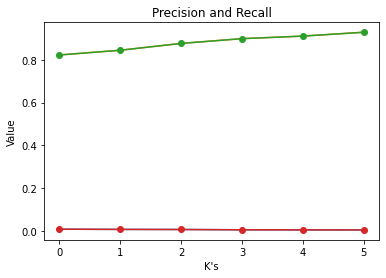

In [54]:
import matplotlib.pyplot as plt

plt.plot(precision_Ks, label="Precision")
plt.plot(recall_Ks, label="Recall")

plt.title("Precision and Recall")
plt.xlabel("K's")
plt.ylabel("Value")
plt.plot(recall_Ks, marker = 'o')
plt.plot(precision_Ks, marker = 'o')

plt.show()

In [14]:

  
#Alternativa fora da função

#filt_cand = dict()
#for (query, query_topic) in query_to_dominant.items():
#    answers=[]
#    for (candidate, topk) in documents_topk_map_max.items():
#        top_k_candidates = topk.replace("[","").replace("]","").split() # ['94', '5', '105', '3', '20']
 #       if (convert_float_to_int_string(query_topic) in top_k_candidates):
  #          index = top_k_candidates.index(convert_float_to_int_string(query_topic))
   #         answers.append([candidate,index+1])
    #    else:
     #       continue
        #answers.append([candidate,'NA'])
  #  filt_cand[query] = answers

['072495.txt', '082291.txt', '004851.txt', '049315.txt']
4415
